In [104]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier


In [105]:
scada_df = pd.read_csv('scada_data.csv')
scada_df['DateTime'] = pd.to_datetime(scada_df['DateTime'])
scada_df.head()

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,2014-05-01 00:00:00,1398920448,0,6.900,9.400,2.900,0.000,0.020,0.000,0,...,24,20,25,12,14,24,34,2501,25.273,1.104
1,2014-05-01 00:09:00,1398920960,0,5.300,8.900,1.600,0.000,0.010,0.000,0,...,24,20,25,12,14,24,34,2501,25.273,1.104
2,2014-05-01 00:20:00,1398921600,0,5.000,9.500,1.400,0.000,0.040,0.000,0,...,24,20,25,12,14,24,34,2501,25.273,1.104
3,2014-05-01 00:30:00,1398922240,0,4.400,8.300,1.300,0.000,0.080,0.000,0,...,23,21,25,12,14,24,34,2501,25.273,1.104
4,2014-05-01 00:39:00,1398922752,0,5.700,9.700,1.200,0.000,0.050,0.000,0,...,23,21,25,12,14,23,34,2501,25.273,1.104


In [106]:
status_df = pd.read_csv('status_data.csv')
status_df['Time'] = pd.to_datetime(status_df['Time'])
status_df.rename(columns={'Time': 'DateTime'}, inplace=True)

status_df

C:\Users\prana\AppData\Local\Temp\ipykernel_4984\1994723008.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  status_df['Time'] = pd.to_datetime(status_df['Time'])


,DateTime,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
0,2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.400
1,2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.500
2,2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.100
3,2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.700
4,2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.600
...,...,...,...,...,...,...,...,...,...
1844,2015-04-27 07:26:51,0,0,0 : 0,Turbine in operation,1,False,False,7.000
1845,2015-04-28 22:14:25,26,373,26 : 373,Malfunction fan-inverter : Other control board...,6,False,False,8.100
1846,2015-04-28 22:14:53,0,2,0 : 2,Turbine operational,1,False,False,9.500
1847,2015-04-28 22:17:15,0,1,0 : 1,Turbine starting,1,False,False,11.100


In [107]:
fault_df = pd.read_csv('fault_data.csv')
fault_df['DateTime'] = pd.to_datetime(fault_df['DateTime'])

fault_df

,DateTime,Time,Fault
0,2014-05-14 14:39:44,1400096384.000,GF
1,2014-05-14 14:50:24,1400097024.000,GF
2,2014-05-14 14:58:56,1400097536.000,GF
3,2014-05-14 15:09:36,1400098176.000,GF
4,2014-05-14 15:20:16,1400098816.000,GF
...,...,...,...
548,2015-01-14 23:00:48,1421298048.000,AF
549,2015-01-14 23:09:20,1421298560.000,AF
550,2015-01-15 22:50:08,1421383808.000,AF
551,2015-01-15 23:00:48,1421384448.000,AF


In [108]:
fault_df.Fault.unique()

array(['GF', 'MF', 'FF', 'AF', 'EF'], dtype=object)

C:\Users\prana\AppData\Local\Temp\ipykernel_4984\621526021.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fault_df.resample('M', on='DateTime').Fault.count().plot.bar()


<Axes: xlabel='DateTime'>

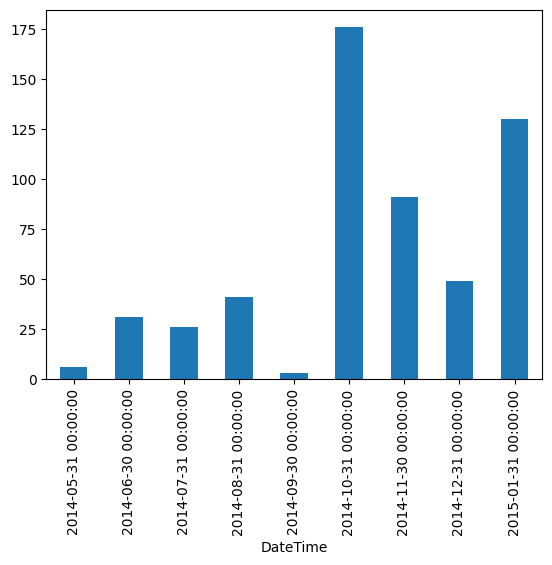

In [109]:
fault_df.resample('M', on='DateTime').Fault.count().plot.bar()

In [110]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

C:\Users\prana\AppData\Local\Temp\ipykernel_4984\1399793357.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fault_df.resample('M', on='DateTime').Fault.value_counts().unstack().plot.bar(stacked=True, width=0.8, figsize=(10,5), color=c, rot=45,


<Axes: title={'center': 'Wind Turbine Faults'}, xlabel='DateTime', ylabel='Fault Counts'>

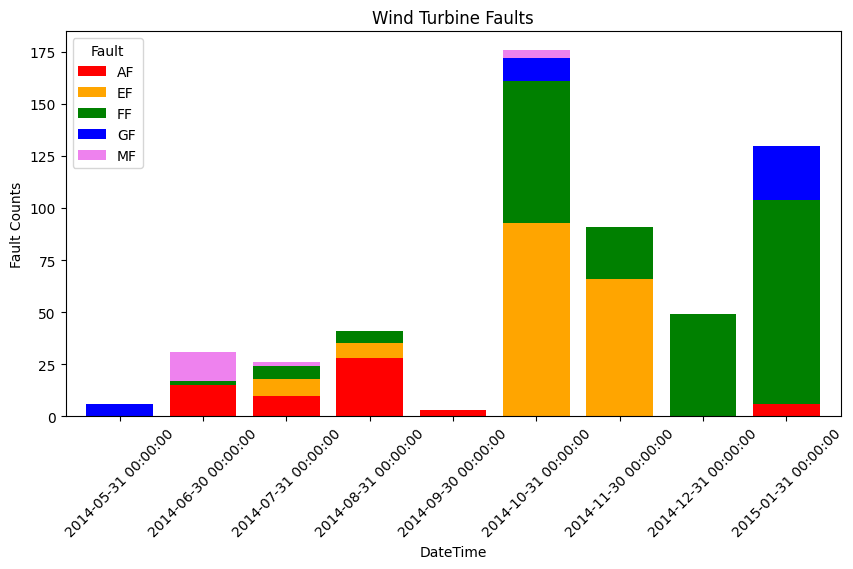

In [111]:
c = ['red', 'orange', 'green', 'blue', 'violet']
fault_df.resample('M', on='DateTime').Fault.value_counts().unstack().plot.bar(stacked=True, width=0.8, figsize=(10,5), color=c, rot=45,
                                                                              title='Wind Turbine Faults', ylabel='Fault Counts')

<Axes: >

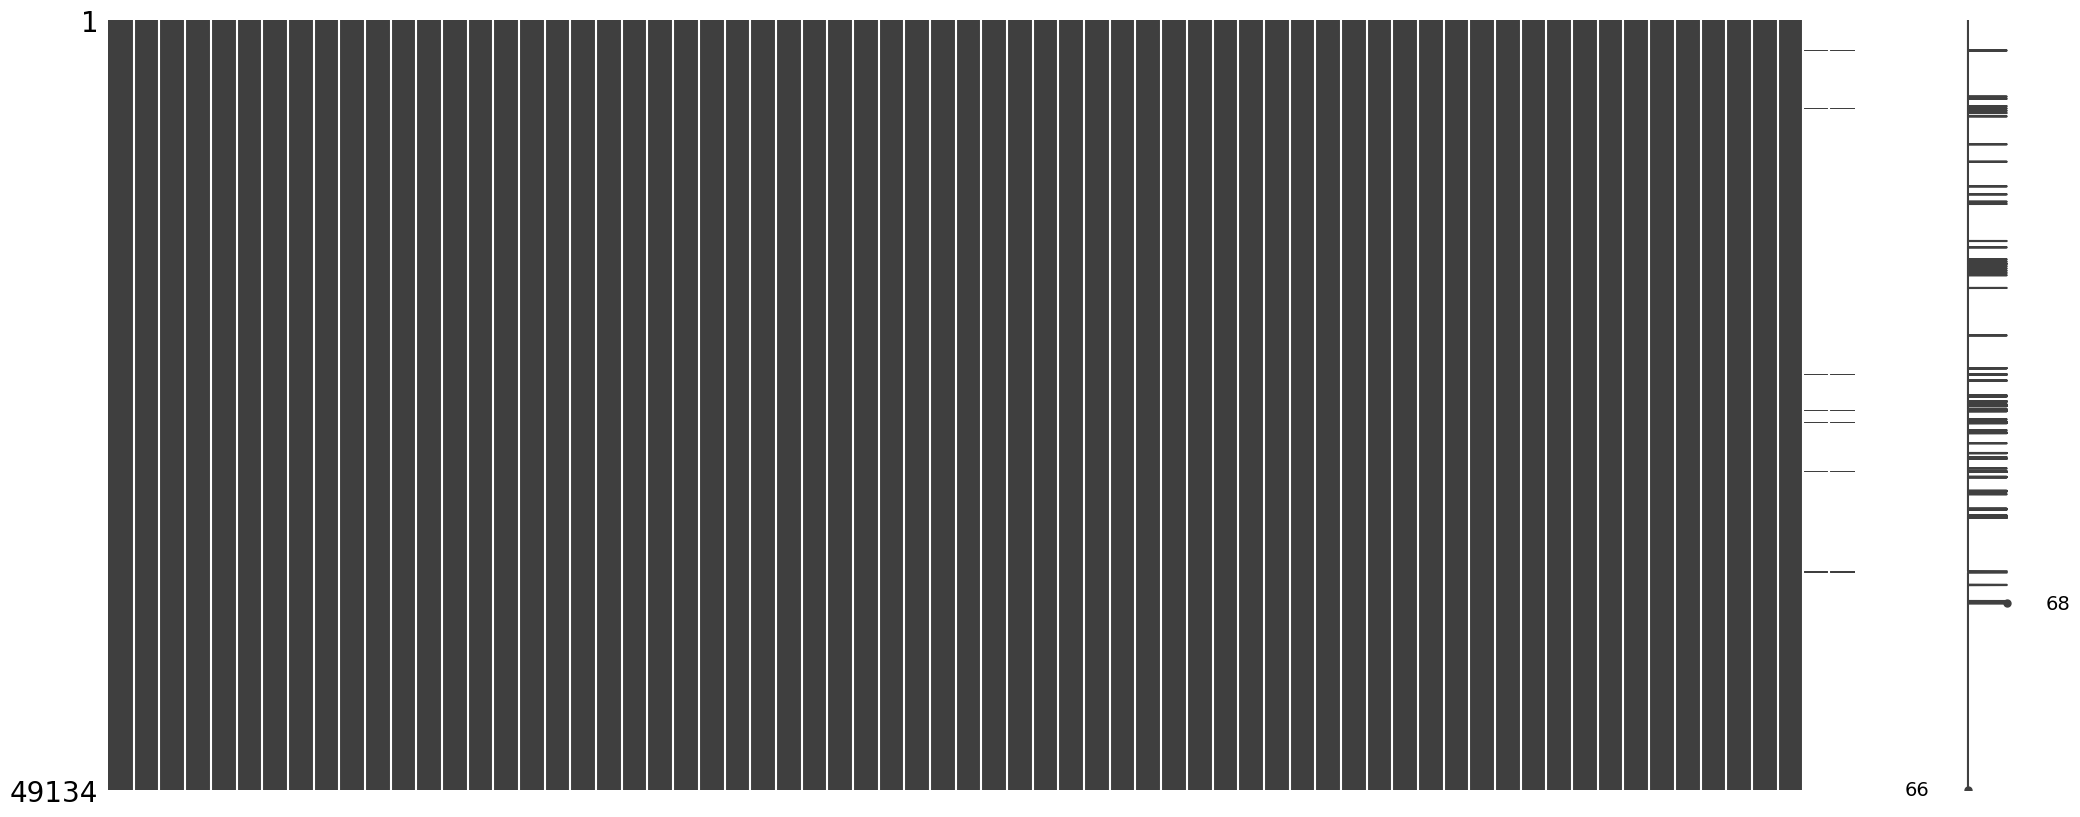

In [112]:
df_combine = scada_df.merge(fault_df, on='Time', how='outer')
msno.matrix(df_combine)

In [113]:
df_combine['Fault'] = df_combine['Fault'].replace(np.nan, 'NF')

df_combine

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-05-01 00:00:00,1398920448,0,6.900,9.400,2.900,0.000,0.020,0.000,0,...,25,12,14,24,34,2501,25.273,1.104,NaT,NF
1,2014-05-01 00:09:00,1398920960,0,5.300,8.900,1.600,0.000,0.010,0.000,0,...,25,12,14,24,34,2501,25.273,1.104,NaT,NF
2,2014-05-01 00:20:00,1398921600,0,5.000,9.500,1.400,0.000,0.040,0.000,0,...,25,12,14,24,34,2501,25.273,1.104,NaT,NF
3,2014-05-01 00:30:00,1398922240,0,4.400,8.300,1.300,0.000,0.080,0.000,0,...,25,12,14,24,34,2501,25.273,1.104,NaT,NF
4,2014-05-01 00:39:00,1398922752,0,5.700,9.700,1.200,0.000,0.050,0.000,0,...,25,12,14,23,34,2501,25.273,1.104,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,2015-04-08 23:20:00,1428553216,0,3.900,5.500,2.200,6.750,7.400,6.010,147,...,28,9,17,27,35,3050,24.455,3.475,NaT,NF
49130,2015-04-08 23:30:00,1428553856,0,3.900,5.600,2.900,6.640,7.060,6.330,128,...,28,9,17,27,35,3050,24.455,3.446,NaT,NF
49131,2015-04-08 23:39:00,1428554368,0,4.200,6.700,2.600,7.180,8.830,6.220,163,...,28,9,18,27,34,3050,24.364,3.414,NaT,NF
49132,2015-04-08 23:50:00,1428555008,0,4.100,6.600,2.700,7.020,7.940,6.200,160,...,28,9,17,27,34,3050,24.000,3.376,NaT,NF


In [114]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_summary = df_combine.groupby('Fault').mean().T
df_summary.tail(20)

Fault,AF,EF,FF,GF,MF,NF
Rotor temp. 1,55.565,100.368,66.071,34.140,52.300,52.517
Rotor temp. 2,55.677,99.920,65.925,34.860,52.500,52.614
Stator temp. 1,68.903,101.592,70.425,42.837,66.350,60.702
Stator temp. 2,68.323,100.454,69.720,42.465,65.850,60.204
Nacelle ambient temp. 1,15.629,14.500,11.016,12.116,14.800,12.515
Nacelle ambient temp. 2,15.629,14.299,10.917,11.930,14.650,12.435
Nacelle temp.,19.290,17.368,14.051,14.093,17.850,16.339
Nacelle cabinet temp.,22.919,20.736,17.831,19.395,21.000,19.852
Main carrier temp.,20.548,19.632,15.866,13.279,19.100,16.551
Rectifier cabinet temp.,32.629,30.385,26.697,30.767,30.000,30.354


In [115]:
df_combine.Fault.value_counts()

Fault
NF    48581
FF      254
EF      174
AF       62
GF       43
MF       20
Name: count, dtype: int64

In [116]:
df_nf = df_combine[df_combine.Fault=='NF'].sample(300, random_state=42)

df_nf

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
7340,2014-06-21 19:29:00,1403396992,0,3.500,4.600,2.400,6.370,6.640,6.160,87,...,40,20,26,36,45,3050,34.273,3.228,NaT,NF
949,2014-05-07 16:39:00,1399498752,0,5.300,15.000,3.000,0.000,0.000,0.000,0,...,26,16,15,24,33,2501,24.455,0.934,NaT,NF
37369,2015-01-17 00:00:00,1421474432,0,9.200,10.800,8.100,13.480,13.950,12.920,2078,...,20,3,18,25,40,3050,19.091,1.446,NaT,NF
15200,2014-08-15 07:30:00,1408105856,0,7.200,9.600,5.000,10.450,11.620,9.700,998,...,30,21,30,37,48,3050,30.545,1.036,NaT,NF
42798,2015-02-23 22:30:00,1424752256,0,14.900,20.900,11.200,14.690,15.540,14.130,3060,...,22,6,28,39,67,3050,28.273,1.902,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6298,2014-06-14 13:50:00,1402771840,0,2.200,4.300,0.400,4.600,5.120,4.150,1,...,40,24,25,35,45,3050,35.000,1.414,NaT,NF
22374,2014-10-04 01:38:00,1412404736,0,7.100,9.000,5.500,10.120,10.770,9.500,875,...,27,13,26,34,43,3050,28.091,1.136,NaT,NF
39742,2015-02-02 16:41:00,1422916864,0,2.100,2.600,1.700,5.050,5.320,4.940,6,...,21,4,8,17,27,3050,19.909,1.044,NaT,NF
34504,2014-12-28 02:40:00,1419756032,0,7.800,9.500,5.200,10.670,11.720,9.360,1138,...,22,4,19,27,38,3050,19.818,0.603,NaT,NF


In [117]:
df_f = df_combine[df_combine.Fault!='NF']

df_f

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
1945,2014-05-14 14:39:00,1400096384,0,5.700,7.400,4.100,9.980,10.230,9.720,0,...,27,17,26,35,34,2501,25.818,0.603,2014-05-14 14:39:44,GF
1946,2014-05-14 14:50:00,1400097024,0,6.400,8.600,2.700,4.120,10.710,0.700,0,...,27,17,26,35,34,2501,26.091,0.944,2014-05-14 14:50:24,GF
1947,2014-05-14 14:58:00,1400097536,0,5.600,7.500,4.000,9.990,10.200,9.800,0,...,27,17,26,35,34,2501,26.455,0.820,2014-05-14 14:58:56,GF
1948,2014-05-14 15:09:00,1400098176,0,5.300,6.600,4.100,9.980,10.170,9.790,0,...,27,18,26,35,34,2501,26.182,0.874,2014-05-14 15:09:36,GF
1949,2014-05-14 15:20:00,1400098816,0,5.100,7.200,3.800,9.990,10.170,9.800,0,...,28,18,26,35,34,2501,26.182,0.982,2014-05-14 15:20:16,GF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2015-01-14 23:00:00,1421298048,0,13.500,22.000,7.700,14.690,15.190,13.830,2736,...,24,8,29,35,57,3050,25.909,1.814,2015-01-14 23:00:48,AF
37076,2015-01-14 23:09:00,1421298560,0,15.500,25.700,1.900,2.530,14.670,0.000,20,...,23,7,22,35,57,3050,28.182,1.834,2015-01-14 23:09:20,AF
37218,2015-01-15 22:50:00,1421383808,0,8.400,9.700,6.800,12.790,13.300,11.640,1667,...,21,5,21,28,42,3050,20.909,1.300,2015-01-15 22:50:08,AF
37219,2015-01-15 23:00:00,1421384448,0,8.100,9.800,6.000,11.710,13.270,9.990,1311,...,20,5,21,28,42,3050,20.909,1.300,2015-01-15 23:00:48,AF


In [118]:
df_combine = pd.concat((df_nf, df_f), axis=0).reset_index(drop=True)

df_combine

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-06-21 19:29:00,1403396992,0,3.500,4.600,2.400,6.370,6.640,6.160,87,...,40,20,26,36,45,3050,34.273,3.228,NaT,NF
1,2014-05-07 16:39:00,1399498752,0,5.300,15.000,3.000,0.000,0.000,0.000,0,...,26,16,15,24,33,2501,24.455,0.934,NaT,NF
2,2015-01-17 00:00:00,1421474432,0,9.200,10.800,8.100,13.480,13.950,12.920,2078,...,20,3,18,25,40,3050,19.091,1.446,NaT,NF
3,2014-08-15 07:30:00,1408105856,0,7.200,9.600,5.000,10.450,11.620,9.700,998,...,30,21,30,37,48,3050,30.545,1.036,NaT,NF
4,2015-02-23 22:30:00,1424752256,0,14.900,20.900,11.200,14.690,15.540,14.130,3060,...,22,6,28,39,67,3050,28.273,1.902,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,2015-01-14 23:00:00,1421298048,0,13.500,22.000,7.700,14.690,15.190,13.830,2736,...,24,8,29,35,57,3050,25.909,1.814,2015-01-14 23:00:48,AF
849,2015-01-14 23:09:00,1421298560,0,15.500,25.700,1.900,2.530,14.670,0.000,20,...,23,7,22,35,57,3050,28.182,1.834,2015-01-14 23:09:20,AF
850,2015-01-15 22:50:00,1421383808,0,8.400,9.700,6.800,12.790,13.300,11.640,1667,...,21,5,21,28,42,3050,20.909,1.300,2015-01-15 22:50:08,AF
851,2015-01-15 23:00:00,1421384448,0,8.100,9.800,6.000,11.710,13.270,9.990,1311,...,20,5,21,28,42,3050,20.909,1.300,2015-01-15 23:00:48,AF


In [119]:
train_df = df_combine.drop(columns=['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                    'WEC: ava. available P from wind',
                                    'WEC: ava. available P technical reasons',
                                    'WEC: ava. Available P force majeure reasons',
                                    'WEC: ava. Available P force external reasons',
                                    'WEC: max. windspeed', 'WEC: min. windspeed', 
                                    'WEC: Operating Hours', 'WEC: Production kWh',
                                    'WEC: Production minutes', 'DateTime_y'])

train_df

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,6.370,6.640,6.160,87,123,65,171,32,32,32,...,36,40,20,26,36,45,3050,34.273,3.228,NF
1,0.000,0.000,0.000,0,0,0,-52,0,0,0,...,22,26,16,15,24,33,2501,24.455,0.934,NF
2,13.480,13.950,12.920,2078,2533,1696,-66,173,204,152,...,16,20,3,18,25,40,3050,19.091,1.446,NF
3,10.450,11.620,9.700,998,1491,710,-376,64,79,55,...,24,30,21,30,37,48,3050,30.545,1.036,NF
4,14.690,15.540,14.130,3060,3114,2994,-68,296,299,294,...,19,22,6,28,39,67,3050,28.273,1.902,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,14.690,15.190,13.830,2736,2798,2417,-78,238,243,224,...,21,24,8,29,35,57,3050,25.909,1.814,AF
849,2.530,14.670,0.000,20,2746,0,-76,4,241,0,...,21,23,7,22,35,57,3050,28.182,1.834,AF
850,12.790,13.300,11.640,1667,1914,1259,-66,145,170,119,...,17,21,5,21,28,42,3050,20.909,1.300,AF
851,11.710,13.270,9.990,1311,1945,781,-53,111,155,77,...,16,20,5,21,28,42,3050,20.909,1.300,AF


<Axes: title={'center': 'Fault Modes'}, ylabel='count'>

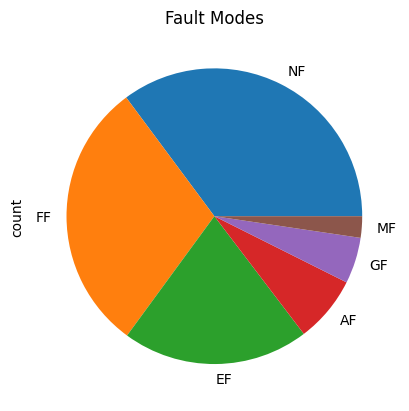

In [120]:
train_df.Fault.value_counts().plot.pie(title='Fault Modes')

In [121]:
X = train_df.iloc[:,:-1]
y = train_df.iloc[:,-1]

In [122]:
print(y)

0      NF
1      NF
2      NF
3      NF
4      NF
       ..
848    AF
849    AF
850    AF
851    AF
852    AF
Name: Fault, Length: 853, dtype: object


In [123]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [124]:
x_train.head()

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
28,6.110,6.390,5.930,62,95,46,-58,41,50,40,...,27,20,23,9,12,22,32,3050,23.364,2.767
665,9.620,15.680,1.240,1708,3125,0,-189,168,1012,0,...,26,24,26,12,25,35,60,3037,30.182,1.940
193,9.820,11.390,7.690,712,1162,199,-154,70,91,46,...,29,20,26,9,21,29,35,3050,24.545,1.293
404,11.870,13.630,10.450,1622,2621,975,111,98,156,66,...,30,32,34,20,32,39,51,3050,32.818,1.662
465,14.190,14.880,13.520,3070,3152,2988,196,212,217,209,...,34,30,33,18,27,38,68,3050,38.273,0.905


In [125]:
x_test.head()

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
66,12.560,13.520,11.140,1938,2505,1285,-80,168,215,123,...,27,23,28,14,25,32,44,3050,25.727,1.272
434,14.180,15.640,13.430,3068,3160,2982,-160,207,210,205,...,28,26,28,15,33,42,69,3050,33.727,1.618
198,10.950,12.410,9.830,1025,1504,721,375,5,10,2,...,29,25,30,14,25,32,42,2501,26.182,0.982
212,14.180,14.900,13.390,3047,3148,2424,-55,276,283,234,...,23,20,23,8,26,36,52,3050,26.273,1.618
652,10.750,12.590,9.600,1136,1958,686,-148,143,226,103,...,27,21,26,12,21,28,37,3050,22.727,1.421


In [126]:
y_train.head()

28     NF
665    EF
193    NF
404    AF
465    FF
Name: Fault, dtype: object

In [127]:
y_test.head()

66     NF
434    FF
198    NF
212    NF
652    FF
Name: Fault, dtype: object

NORMALIZING THE INPUTS

In [128]:
scl = StandardScaler()

In [129]:
X_train = scl.fit_transform(x_train)
X_test = scl.transform(x_test)

LOGISTIC REGRESSION

In [130]:
A = linear_model.LogisticRegression()
A.fit(X_train, y_train)


c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [131]:
A_lr = A.predict(X_test)
A_lr

array(['NF', 'EF', 'NF', 'NF', 'FF', 'GF', 'NF', 'NF', 'AF', 'FF', 'NF',
       'EF', 'FF', 'MF', 'AF', 'EF', 'EF', 'EF', 'FF', 'GF', 'NF', 'EF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'FF', 'NF', 'EF', 'EF', 'EF', 'FF',
       'FF', 'FF', 'FF', 'NF', 'EF', 'NF', 'FF', 'NF', 'NF', 'EF', 'NF',
       'NF', 'NF', 'AF', 'GF', 'EF', 'EF', 'EF', 'FF', 'NF', 'FF', 'EF',
       'EF', 'EF', 'NF', 'NF', 'FF', 'NF', 'EF', 'NF', 'EF', 'FF', 'FF',
       'NF', 'FF', 'GF', 'NF', 'NF', 'FF', 'NF', 'FF', 'NF', 'NF', 'EF',
       'AF', 'NF', 'NF', 'FF', 'FF', 'GF', 'FF', 'NF', 'NF', 'EF', 'EF',
       'FF', 'EF', 'NF', 'NF', 'EF', 'NF', 'NF', 'NF', 'NF', 'AF', 'FF',
       'NF', 'NF', 'NF', 'FF', 'NF', 'NF', 'NF', 'EF', 'NF', 'NF', 'NF',
       'FF', 'GF', 'FF', 'NF', 'NF', 'FF', 'NF', 'AF', 'EF', 'EF', 'EF',
       'EF', 'EF', 'EF', 'FF', 'EF', 'NF', 'NF', 'AF', 'EF', 'AF', 'NF',
       'NF', 'FF', 'FF', 'EF', 'FF', 'GF', 'NF', 'NF', 'EF', 'EF', 'EF',
       'NF', 'AF', 'NF', 'FF', 'FF', 'FF', 'GF', 'A

[[ 9  2  0  0  2  7]
 [ 0 45 10  0  0  2]
 [ 0 21 46  0  1  8]
 [ 0  0  1  9  0  0]
 [ 3  0  0  0  0  4]
 [ 3  1  8  0  0 74]] 

0.71484375 

              precision    recall  f1-score   support

          AF       0.60      0.45      0.51        20
          EF       0.65      0.79      0.71        57
          FF       0.71      0.61      0.65        76
          GF       1.00      0.90      0.95        10
          MF       0.00      0.00      0.00         7
          NF       0.78      0.86      0.82        86

    accuracy                           0.71       256
   macro avg       0.62      0.60      0.61       256
weighted avg       0.70      0.71      0.70       256



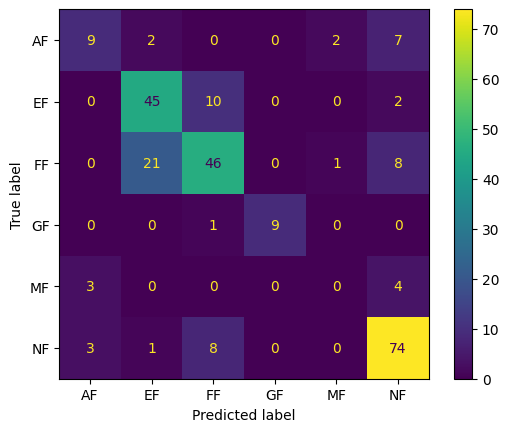

In [132]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,ConfusionMatrixDisplay
matrix_LR=confusion_matrix(y_test,A_lr)
print(matrix_LR,'\n')
print(ConfusionMatrixDisplay.from_predictions(y_test,A_lr))
accuracy_LR=accuracy_score(y_test,A_lr)
print(accuracy_LR,'\n')
report_LR=classification_report(y_test,A_lr)
print(report_LR)

In [133]:
A.score(X_test,y_test)

0.71484375

K - NEAREST NEIGHBOR

In [134]:
B = KNeighborsClassifier(n_neighbors=5)
B.fit(X_train,y_train)

KNeighborsClassifier()

In [135]:
B_knn= B.predict(X_test)
B_knn

array(['NF', 'EF', 'NF', 'NF', 'FF', 'GF', 'NF', 'NF', 'AF', 'FF', 'FF',
       'EF', 'FF', 'MF', 'AF', 'EF', 'EF', 'EF', 'EF', 'GF', 'NF', 'EF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'FF', 'NF', 'EF', 'EF', 'EF', 'EF',
       'EF', 'FF', 'FF', 'AF', 'EF', 'NF', 'FF', 'FF', 'NF', 'EF', 'NF',
       'AF', 'NF', 'NF', 'GF', 'EF', 'EF', 'EF', 'EF', 'NF', 'FF', 'EF',
       'EF', 'EF', 'NF', 'NF', 'FF', 'NF', 'EF', 'NF', 'EF', 'NF', 'AF',
       'NF', 'FF', 'GF', 'NF', 'NF', 'FF', 'NF', 'FF', 'FF', 'NF', 'FF',
       'EF', 'NF', 'NF', 'FF', 'FF', 'GF', 'FF', 'FF', 'FF', 'EF', 'EF',
       'FF', 'EF', 'NF', 'NF', 'EF', 'FF', 'NF', 'NF', 'NF', 'AF', 'FF',
       'NF', 'NF', 'FF', 'FF', 'EF', 'FF', 'NF', 'FF', 'NF', 'NF', 'NF',
       'FF', 'GF', 'FF', 'NF', 'FF', 'FF', 'FF', 'NF', 'EF', 'FF', 'EF',
       'EF', 'EF', 'EF', 'FF', 'EF', 'NF', 'NF', 'NF', 'EF', 'AF', 'NF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'GF', 'NF', 'FF', 'EF', 'FF', 'EF',
       'NF', 'AF', 'NF', 'NF', 'FF', 'FF', 'GF', 'N

[[ 9  3  1  0  2  5]
 [ 0 38 19  0  0  0]
 [ 1 26 47  0  0  2]
 [ 0  0  1  9  0  0]
 [ 2  0  0  0  0  5]
 [ 6  1 12  0  0 67]] 

0.6640625 

              precision    recall  f1-score   support

          AF       0.50      0.45      0.47        20
          EF       0.56      0.67      0.61        57
          FF       0.59      0.62      0.60        76
          GF       1.00      0.90      0.95        10
          MF       0.00      0.00      0.00         7
          NF       0.85      0.78      0.81        86

    accuracy                           0.66       256
   macro avg       0.58      0.57      0.57       256
weighted avg       0.66      0.66      0.66       256



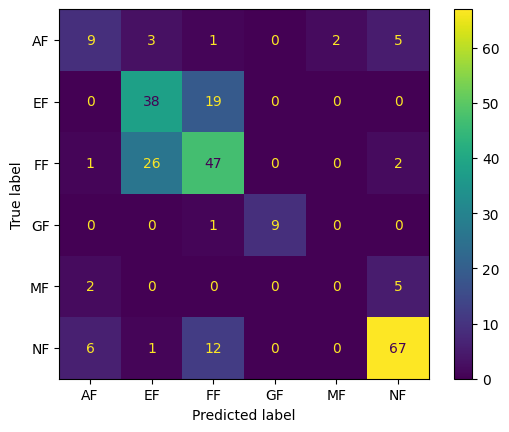

In [136]:
matrix_KNN=confusion_matrix(y_test,B_knn)
print(matrix_KNN,'\n')
print(ConfusionMatrixDisplay.from_predictions(y_test,B_knn))
accuracy_KNN=accuracy_score(y_test,B_knn)
print(accuracy_KNN,'\n')
report_KNN=classification_report(y_test,B_knn)
print(report_KNN)

In [137]:
B.score(X_test,y_test)

0.6640625

DECISION TREE

In [138]:
C=DecisionTreeClassifier(criterion='entropy')
C.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [139]:
C_dt=C.predict(X_test)
C_dt

array(['NF', 'EF', 'NF', 'NF', 'FF', 'GF', 'NF', 'NF', 'AF', 'FF', 'FF',
       'EF', 'FF', 'MF', 'AF', 'EF', 'EF', 'EF', 'EF', 'GF', 'NF', 'EF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'FF', 'AF', 'NF', 'EF', 'EF', 'EF',
       'NF', 'FF', 'FF', 'AF', 'FF', 'NF', 'FF', 'NF', 'AF', 'EF', 'NF',
       'MF', 'NF', 'AF', 'GF', 'EF', 'EF', 'EF', 'FF', 'NF', 'FF', 'EF',
       'EF', 'EF', 'NF', 'NF', 'FF', 'NF', 'EF', 'NF', 'EF', 'FF', 'NF',
       'NF', 'FF', 'GF', 'NF', 'NF', 'FF', 'NF', 'FF', 'FF', 'AF', 'EF',
       'FF', 'AF', 'NF', 'FF', 'NF', 'GF', 'FF', 'FF', 'FF', 'EF', 'FF',
       'FF', 'FF', 'NF', 'NF', 'EF', 'FF', 'NF', 'NF', 'NF', 'AF', 'FF',
       'NF', 'NF', 'FF', 'FF', 'EF', 'NF', 'NF', 'FF', 'NF', 'NF', 'NF',
       'FF', 'GF', 'FF', 'NF', 'NF', 'FF', 'AF', 'EF', 'EF', 'EF', 'EF',
       'EF', 'EF', 'FF', 'NF', 'NF', 'AF', 'NF', 'AF', 'EF', 'NF', 'NF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'GF', 'NF', 'NF', 'EF', 'EF', 'EF',
       'NF', 'AF', 'NF', 'NF', 'FF', 'FF', 'GF', 'A

[[10  2  1  0  3  4]
 [ 0 29 24  0  0  4]
 [ 0 27 46  1  0  2]
 [ 0  0  1  9  0  0]
 [ 5  0  0  0  0  2]
 [13  3  3  0  0 67]] 

0.62890625 

              precision    recall  f1-score   support

          AF       0.36      0.50      0.42        20
          EF       0.48      0.51      0.49        57
          FF       0.61      0.61      0.61        76
          GF       0.90      0.90      0.90        10
          MF       0.00      0.00      0.00         7
          NF       0.85      0.78      0.81        86

    accuracy                           0.63       256
   macro avg       0.53      0.55      0.54       256
weighted avg       0.64      0.63      0.63       256



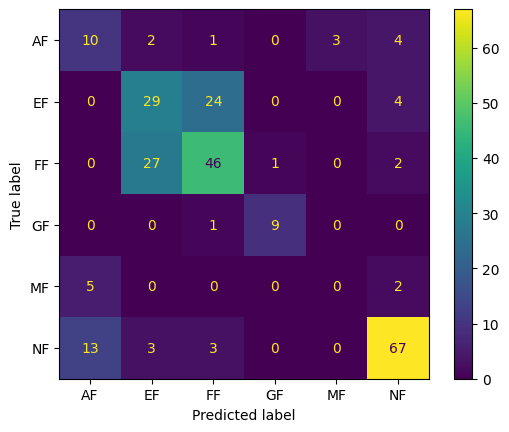

In [140]:
matrix_DT=confusion_matrix(y_test,C_dt)
print(matrix_DT,'\n')
print(ConfusionMatrixDisplay.from_predictions(y_test,C_dt))
accuracy_DT=accuracy_score(y_test,C_dt)
print(accuracy_DT,'\n')
report_DT=classification_report(y_test,C_dt)
print(report_DT)

In [141]:
C.score(X_test,y_test)

0.62890625

RANDOM FOREST

In [142]:
D=RandomForestClassifier(n_estimators=10,criterion='entropy')
D.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [143]:
D_rf = D.predict(X_test)
D_rf

array(['NF', 'EF', 'NF', 'NF', 'FF', 'GF', 'NF', 'NF', 'AF', 'FF', 'NF',
       'EF', 'FF', 'MF', 'AF', 'EF', 'EF', 'EF', 'FF', 'GF', 'NF', 'EF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'FF', 'NF', 'EF', 'EF', 'EF', 'FF',
       'EF', 'FF', 'FF', 'AF', 'FF', 'NF', 'FF', 'NF', 'NF', 'EF', 'NF',
       'MF', 'NF', 'NF', 'GF', 'EF', 'EF', 'EF', 'FF', 'NF', 'FF', 'EF',
       'EF', 'EF', 'NF', 'NF', 'FF', 'NF', 'EF', 'FF', 'EF', 'FF', 'NF',
       'NF', 'FF', 'GF', 'NF', 'NF', 'FF', 'NF', 'FF', 'FF', 'NF', 'EF',
       'AF', 'AF', 'NF', 'FF', 'NF', 'GF', 'FF', 'FF', 'FF', 'EF', 'FF',
       'FF', 'FF', 'NF', 'NF', 'EF', 'EF', 'NF', 'NF', 'AF', 'MF', 'FF',
       'NF', 'NF', 'FF', 'FF', 'EF', 'NF', 'NF', 'FF', 'NF', 'NF', 'NF',
       'FF', 'GF', 'FF', 'NF', 'NF', 'FF', 'AF', 'AF', 'EF', 'EF', 'EF',
       'EF', 'EF', 'FF', 'NF', 'EF', 'NF', 'NF', 'AF', 'EF', 'AF', 'NF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'GF', 'NF', 'NF', 'EF', 'EF', 'EF',
       'NF', 'AF', 'NF', 'FF', 'FF', 'FF', 'GF', 'A

[[14  2  0  0  3  1]
 [ 0 29 28  0  0  0]
 [ 0 26 48  0  0  2]
 [ 0  0  0 10  0  0]
 [ 3  0  0  0  1  3]
 [ 6  2  3  0  0 75]] 

0.69140625 

              precision    recall  f1-score   support

          AF       0.61      0.70      0.65        20
          EF       0.49      0.51      0.50        57
          FF       0.61      0.63      0.62        76
          GF       1.00      1.00      1.00        10
          MF       0.25      0.14      0.18         7
          NF       0.93      0.87      0.90        86

    accuracy                           0.69       256
   macro avg       0.65      0.64      0.64       256
weighted avg       0.69      0.69      0.69       256



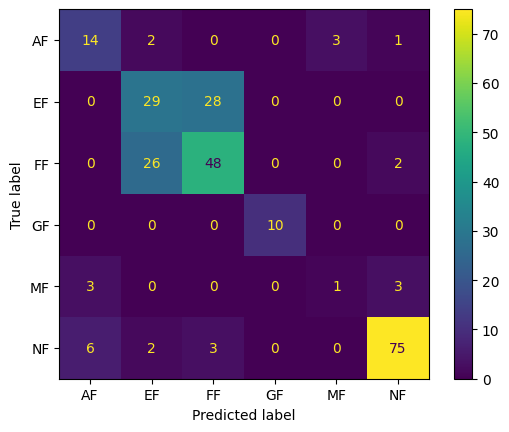

In [144]:
matrix_RF=confusion_matrix(y_test,D_rf)
print(matrix_RF,'\n')
print(ConfusionMatrixDisplay.from_predictions(y_test,D_rf))
accuracy_RF=accuracy_score(y_test,D_rf)
print(accuracy_RF,'\n')
report_RF=classification_report(y_test,D_rf)
print(report_RF)

In [145]:
D.score(X_test,y_test)

0.69140625

SUPPORT VECTOR MACHINES

In [146]:
E = SVC(kernel = 'linear')
E.fit(X_train,y_train)

SVC(kernel='linear')

In [147]:
E_svm = E.predict(X_test)
E_svm

array(['NF', 'EF', 'NF', 'NF', 'NF', 'GF', 'NF', 'NF', 'AF', 'FF', 'NF',
       'EF', 'FF', 'MF', 'AF', 'EF', 'EF', 'EF', 'FF', 'GF', 'NF', 'EF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'FF', 'NF', 'EF', 'EF', 'EF', 'FF',
       'FF', 'FF', 'FF', 'NF', 'EF', 'NF', 'FF', 'NF', 'NF', 'EF', 'NF',
       'NF', 'NF', 'NF', 'GF', 'EF', 'EF', 'EF', 'FF', 'NF', 'FF', 'EF',
       'EF', 'EF', 'NF', 'NF', 'FF', 'NF', 'EF', 'NF', 'EF', 'FF', 'MF',
       'NF', 'FF', 'GF', 'NF', 'NF', 'FF', 'NF', 'FF', 'NF', 'NF', 'EF',
       'AF', 'NF', 'NF', 'FF', 'NF', 'GF', 'FF', 'NF', 'FF', 'EF', 'EF',
       'FF', 'EF', 'NF', 'NF', 'EF', 'EF', 'NF', 'NF', 'NF', 'MF', 'FF',
       'NF', 'NF', 'NF', 'NF', 'EF', 'EF', 'NF', 'EF', 'NF', 'NF', 'NF',
       'FF', 'GF', 'FF', 'NF', 'NF', 'FF', 'NF', 'AF', 'EF', 'EF', 'EF',
       'EF', 'EF', 'FF', 'NF', 'EF', 'NF', 'NF', 'AF', 'EF', 'AF', 'NF',
       'FF', 'FF', 'FF', 'EF', 'FF', 'GF', 'NF', 'NF', 'EF', 'FF', 'EF',
       'FF', 'AF', 'NF', 'NF', 'FF', 'FF', 'GF', 'A

[[ 9  2  0  0  2  7]
 [ 0 43 14  0  0  0]
 [ 0 23 43  0  1  9]
 [ 0  0  0 10  0  0]
 [ 2  0  0  0  2  3]
 [ 2  4  5  0  2 73]] 



0.703125 

              precision    recall  f1-score   support

          AF       0.69      0.45      0.55        20
          EF       0.60      0.75      0.67        57
          FF       0.69      0.57      0.62        76
          GF       1.00      1.00      1.00        10
          MF       0.29      0.29      0.29         7
          NF       0.79      0.85      0.82        86

    accuracy                           0.70       256
   macro avg       0.68      0.65      0.66       256
weighted avg       0.71      0.70      0.70       256



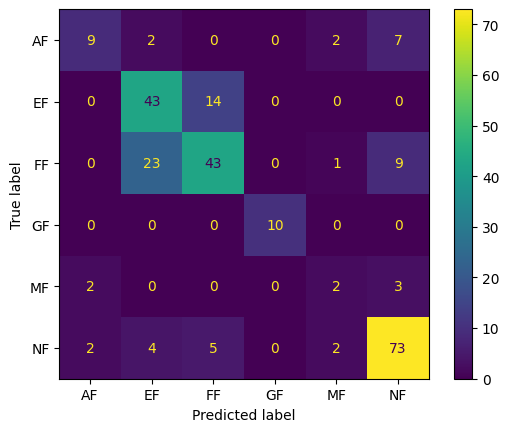

In [148]:
matrix_SVM=confusion_matrix(y_test,E_svm)
print(matrix_SVM,'\n')
print(ConfusionMatrixDisplay.from_predictions(y_test,E_svm))
accuracy_SVM=accuracy_score(y_test,E_svm)
print(accuracy_SVM,'\n')
report_SVM=classification_report(y_test,E_svm)
print(report_SVM)

In [149]:
E.score(X_test,y_test)

0.703125

In [150]:
algo = ['KNEARESTNEIGHBOUR','LOGISTIC REGRESSION','DECISION TREE','RANDOM FOREST','SUPPORT VECTOR MACHINES']
acc=[accuracy_KNN,accuracy_LR,accuracy_DT,accuracy_RF,accuracy_SVM]
Accuracy_Scores=pd.DataFrame({'Algorithms':algo, 'Accuracy': acc})
Accuracy_Scores['Accuracy']=Accuracy_Scores['Accuracy']*100
Accuracy_Scores

,Algorithms,Accuracy
0,KNEARESTNEIGHBOUR,66.406
1,LOGISTIC REGRESSION,71.484
2,DECISION TREE,62.891
3,RANDOM FOREST,69.141
4,SUPPORT VECTOR MACHINES,70.312


In [151]:
Accuracy_Scores.sort_values(by='Accuracy',ascending=False)

,Algorithms,Accuracy
1,LOGISTIC REGRESSION,71.484
4,SUPPORT VECTOR MACHINES,70.312
3,RANDOM FOREST,69.141
0,KNEARESTNEIGHBOUR,66.406
2,DECISION TREE,62.891
